In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import t
import statsmodels.stats.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Table of Contents

- [Exploring the Barcelona accidents statistics](#exploring-the-barcelona-accidents-statistics)
  - [Confidence Interval Method](#confidence-interval)
  - [Hypothesis testing or ab testing for Barcelona accidents with p-value (bootstrap)](#hypothesis-testing-or-ab-testing-for-barcelona-accidents-with-p-value-bootstrap)
- [A/B testing for website variations](#ab-testing-for-website-variations)

## Exploring the Barcelona accidents statistics

In [2]:
data = pd.read_csv(u'datasets/barcelona/2013_ACCIDENTS_GU_BCN_2013.csv')
data.head(1)

,N�mero d'expedient,Codi districte,Nom districte,NK barri,Nom barri,Codi carrer,Nom carrer,Num postal caption,Descripci� dia setmana,Dia de setmana,...,Hora de dia,Descripci� torn,Descripci� causa vianant,N�mero de morts,N�mero de lesionats lleus,N�mero de lesionats greus,N�mero de v�ctimes,N�mero de vehicles implicats,Coordenada UTM (Y),Coordenada UTM (X)
0,2013S007360,-1,Desconegut,-1--1--1,Desconegut,-1,Desconegut,Desconegut,Dimecres,3,...,21,Tarda,Desconegut,0,1,0,1,2,-1,-1


In [3]:
data.shape

(9457, 25)

In [14]:
data['Date'] = data[u'Dia de mes'].apply(lambda x: str(x)) + '-' + data[u'Mes de any'].apply(lambda x: str(x)) + '-2013'

In [15]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [6]:
data['Date'].head()

0   2013-10-16
1   2013-10-29
2   2013-07-23
3   2013-02-26
4   2013-11-18
Name: Date, dtype: datetime64[ns]

In [7]:
accidents_2013 = data.groupby(['Date']).size()
accidents_2013.head()

Date
2013-01-01    16
2013-01-02    18
2013-01-03    17
2013-01-04    29
2013-01-05    17
dtype: int64

In [8]:
accidents_2013.to_numpy()[:10]

array([16, 18, 17, 29, 17, 13, 34, 28, 31, 31], dtype=int64)

In [9]:
round(accidents_2013.mean(), 4)

25.9096

Mean distribution:

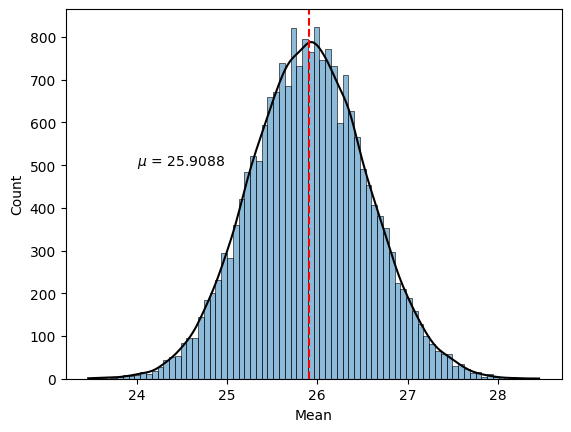

In [10]:
mean_list = []
accidents_array = data.groupby(['Date']).size().to_numpy()
for i in range(20000):
    sample = np.random.choice(accidents_array, 200)
    mean_list.append(sample.mean())

mu = np.mean(mean_list)
ax = sb.histplot(data=mean_list, kde=True)
ax.lines[0].set_color('k')
ax.axvline(mu, color='r', ls='--')
ax.set_xlabel('Mean')
ax.text(24, 500, s=r'$\mu$ = %.4f'%mu)
plt.show()

In [11]:
n = 200
sample = np.random.choice(accidents_2013, n)
SE_1 = sample.std()/np.sqrt(n)
SE_20k = np.std(mean_list)/np.sqrt(n)
print('Standard Error (SE) of 1 Mean Distribution:', round(SE_1, 4))
print('Standard Error (SE) of 20k Mean Distributions:', round(SE_20k, 4))

Standard Error (SE) of 1 Mean Distribution: 0.6619
Standard Error (SE) of 20k Mean Distributions: 0.0455


##### Confidence Interval:

In [12]:
t_value = t(df=200).ppf(0.99)
print('Confidence Interval (99%% C.L.) for one mean sample: %.4f - %.4f'%(np.mean(sample) - t_value * SE_1, np.mean(sample) + t_value * SE_1))
print('Confidence Interval (99%% C.L.) for 20k samples: %.4f - %.4f'%(np.mean(mean_list) - t_value * SE_20k, np.mean(mean_list) + t_value * SE_20k))

Confidence Interval (99% C.L.) for one mean sample: 25.5228 - 28.6272
Confidence Interval (99% C.L.) for 20k samples: 25.8020 - 26.0156


##### Hypothesis Testing or A/B testing for Barcelona accidents with p-value (bootstrap):

In [13]:
data_2010 = pd.read_csv('datasets/barcelona/2010_ACCIDENTS_GU_BCN_2010.csv', encoding='latin-1')

In [14]:
data_2010['Date'] = data_2010[u'Dia de mes'].apply(lambda x: str(x)) + '-' + data_2010[u'Mes de any'].apply(lambda x: str(x)) + '-2013'
data_2010['Date'] = pd.to_datetime(data_2010['Date'], format='%d-%m-%Y')
accidents_2010 = data_2010.groupby(['Date']).size()
accidents_2010.head()

Date
2013-01-01     7
2013-01-02    14
2013-01-03    15
2013-01-04    23
2013-01-05    31
dtype: int64

In [15]:
print(accidents_2013.mean(), accidents_2010.mean())

25.90958904109589 24.81095890410959


In [16]:
t_value = t(df=200).ppf(0.95)
t_value = 1.96

m_2013 = len(data['Date'].value_counts())

mean_2013 = accidents_2013.mean()
SE_2013 = accidents_2013.std()/np.sqrt(m_2013)

print('Confidence Interval (95%% C.L.) for 2013: %.4f - %.4f'%(mean_2013 - t_value * SE_2013, mean_2013 + t_value * SE_2013))

Confidence Interval (95% C.L.) for 2013: 24.9752 - 26.8440


In [17]:
print('mu(2013) - mu(2010) = %.4f'%(accidents_2013.mean() - accidents_2010.mean()))
mu_2013, mu_2010 = accidents_2013.mean(), accidents_2010.mean()
delta = mu_2013 - mu_2010

mu(2013) - mu(2010) = 1.0986


In [18]:
j = 0
N = 200000
n = accidents_2010.shape[0]
accidents = np.concatenate([accidents_2010, accidents_2013])
np.random.shuffle(accidents)

for i in range(N):
    sample1 = np.random.choice(accidents, n)
    sample2 = np.random.choice(accidents, n)
    mu1 = np.mean(sample1)
    mu2 = np.mean(sample2)
    delta_sample = mu1 - mu2
    
    if delta_sample > delta:
        j += 1

p = j/N

print('p-value =', p)

p-value = 0.046595


In [19]:
from scipy.stats import ttest_1samp
ttest_1samp(np.random.choice(accidents, 200), accidents.mean())

Ttest_1sampResult(statistic=-1.9904557922915085, pvalue=0.04790935451637587)

## A/B testing for website variations:

- We state the null hypothesis $H_0$ as: there is no significant difference between the changes of a landing web page.
- The alternative hypothesis $H_A$ can be denoted as the scenario where a significant difference in conversion happened. We set a 1% increase of conversion with the changes (from 20% to 21%).

We set the significance to $\alpha = 0.05$.

In [3]:
ab_data = pd.read_csv('datasets/AB/ab_data.csv')
ab_data.shape

(294478, 5)

In [21]:
ab_lc = ab_data[['landing_page', 'converted']]
print(ab_lc[ab_data['landing_page'] == 'old_page']['converted'].sum() / len(ab_lc[ab_data['landing_page'] == 'old_page']['converted']))
print(ab_lc[ab_data['landing_page'] == 'new_page']['converted'].sum() / len(ab_lc[ab_data['landing_page'] == 'new_page']['converted']))

0.12047759085568362
0.11884079625642663


Firstly we use a **single sample** instead the whole dataset. To calculate sample size we use the **Power of the test** to the conventional $1 - \beta = 0.8$.

In [22]:
effect_size = sm.proportion_effectsize(0.2, 0.21)

required_n = sm.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )

required_n = int(np.ceil(required_n))

print(required_n)

25580


In [33]:
control_sample = ab_data[ab_data['landing_page'] == 'old_page'].sample(required_n, random_state=22)
treatment_sample = ab_data[ab_data['landing_page'] == 'new_page'].sample(required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

successes = [control_results.sum(), treatment_results.sum()]
nobs = [control_results.count(), treatment_results.count()]

z_stat, pvalue = proportions_ztest(successes, nobs=nobs)
(lower_control, lower_treat), (upper_control, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(pvalue)
print((lower_control, lower_treat), (upper_control, upper_treat))

0.0693865692764042
(0.1197527043948647, 0.11458696072236288) (0.12782390598662371, 0.12251031797641723)
